In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, Multiply,Average, Subtract
from tensorflow.keras import Model
import traffic_data_generator
import traffic_util

Fix the random seeds in numpy, tensorlfow

In [4]:
import random as rn

rand_seed=116
rn.seed(rand_seed)
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)

In [10]:
example_name="traffic"
data_dir=traffic_data_generator.set_up(example_name)

In [11]:
delta_gen=0.05
n_traj=5000
n_samples=100000
len_hist_MZ=20
Delta_t=0.5

In [12]:
#===========================
#     Output directories 
#===========================
experiment_name="_no_share"+ \
     "_"+str(n_samples)+"_Delta_"+str(delta_gen)


model_dir=example_name+"/"+experiment_name
plot_dir=model_dir+"/Plots"
checkpoint_dir=model_dir+"/check_points"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [54]:
# inits=['Orthogonal', 'glorot_normal','he_normal' ,'he_uniform', 'glorot_uniform']
n_starts=3
inits=['glorot_normal','he_normal' ,'he_uniform']
rand_seed_shift=0
n_epochs=2000
combinations=np.array([[20,.5]])
np.savetxt(data_dir+'/combinations'+ str(len(combinations)) +'.txt', combinations)
n_new_combo=1
val_loss_log=np.zeros([len(combinations),n_starts,n_epochs])
loss_log=np.zeros([len(combinations),n_starts,n_epochs])
min_log=np.zeros([len(combinations),n_starts])

early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=1, mode='min',
    baseline=None, restore_best_weights=True
)



In [69]:
for i_combo in range(len(combinations)):
    for i_start in range(1):
        opt_model_path=checkpoint_dir+"/opt_model_first_try" +str(i_start)+ '_' +str(i_combo) +".h5"
        if not os.path.exists(opt_model_path):
            print([i_combo,i_start])
            i_hist_MZ=combinations[i_combo,0]
            i_Delta=combinations[i_combo,1]
            len_hist_MZ=int(i_hist_MZ)
            x=np.load(data_dir+'/x_delta_t='+str(i_Delta)+ 'MZ_hist='+str(len_hist_MZ) +'.npy')
            y_temp=np.load(data_dir+'/y_delta_t='+str(i_Delta)+ 'MZ_hist='+str(len_hist_MZ) +'.npy')
            exec('y_shift'+str(i_combo)+'=traffic_util.min_max_scale()')
            exec('y=y_shift'+str(i_combo)+'.fit_transform((y_temp-x[:,0,:]))')
            tf.random.set_seed(rand_seed_shift+i_start+i_combo*10)
            if x.shape[0]==y.shape[0]:
                n_data=x.shape[0]
            else:
                break
            x=x.reshape([n_data,-1])

            states = Input(shape=(x.shape[1],))
            x1=states
            x2=Dense(150, activation='relu',kernel_initializer=inits[i_start%(len(inits)-1)])(x1)
            x3=Dense(100, activation='relu',kernel_initializer=inits[i_start%(len(inits)-1)])(x2)
            x4=Dense(70, activation='tanh',kernel_initializer=inits[i_start%(len(inits)-1)])(x3)
            x_output=Dense(y.shape[1],activation='linear')(x4)
            outputs=x_output
            model=Model(inputs=states, outputs=outputs)  
            learning_rate=0.001
            batch_size=30
            adam=tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-12, decay=0.0, amsgrad=False)
            model.compile(optimizer=adam, loss='mean_squared_error')
            savebest= tf.keras.callbacks.ModelCheckpoint(
                                filepath=opt_model_path, monitor='val_loss', verbose=1, save_best_only=True,
                                save_weights_only=False, mode='auto', save_freq='epoch'
                                )
            #     lr_decrease=bursting_util.ReduceLROnPlateau(
            #                         monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto',
            #                         min_delta=0, cooldown=0, min_lr=10**-12,filepath=opt_model_path
            #                         )
            lr_decrease=tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto',
                            min_delta=0, cooldown=0, min_lr=10**-15
                            )
            hist = model.fit(x, y, 
                          batch_size=batch_size,
                          epochs=n_epochs, 
                          verbose=1,
                          callbacks=[savebest,lr_decrease,early_stop],
                          validation_split=.2,
                        )
            val_loss_log[i_combo,i_start,:]=np.concatenate((hist.history['val_loss'],100*np.ones(n_epochs-len(hist.history['val_loss']))))
            loss_log[i_combo,i_start,:]=np.concatenate((hist.history['loss'],100*np.ones(n_epochs-len(hist.history['loss']))))
            min_log[i_combo,i_start]=np.min(hist.history['val_loss'])

[0, 0]
Train on 80000 samples, validate on 20000 samples
Epoch 1/2000
79680/80000 [============================>.] - ETA: 0s - loss: 0.0291
Epoch 00001: val_loss improved from inf to 0.02924, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 9s 106us/sample - loss: 0.0291 - val_loss: 0.0292
Epoch 2/2000
79620/80000 [============================>.] - ETA: 0s - loss: 0.0289
Epoch 00002: val_loss improved from 0.02924 to 0.02905, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0289 - val_loss: 0.0290
Epoch 3/2000
79590/80000 [============================>.] - ETA: 0s - loss: 0.0288
Epoch 00003: val_loss did not improve from 0.02905
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0288 - val_loss: 0.0291
Epoch 4/2000
79770/80000 [============================>.] - ETA:

79950/80000 [============================>.] - ETA: 0s - loss: 0.0286
Epoch 00032: val_loss did not improve from 0.02891
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0286 - val_loss: 0.0289
Epoch 33/2000
79620/80000 [============================>.] - ETA: 0s - loss: 0.0286
Epoch 00033: val_loss improved from 0.02891 to 0.02885, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0286 - val_loss: 0.0288
Epoch 34/2000
79710/80000 [============================>.] - ETA: 0s - loss: 0.0286
Epoch 00034: val_loss did not improve from 0.02885
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0286 - val_loss: 0.0289
Epoch 35/2000
79830/80000 [============================>.] - ETA: 0s - loss: 0.0285
Epoch 00035: val_loss did not improve from 0.02885
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0285 - val_loss: 0

79410/80000 [============================>.] - ETA: 0s - loss: 0.0258
Epoch 00062: val_loss did not improve from 0.02591
80000/80000 [==============================] - 10s 121us/sample - loss: 0.0258 - val_loss: 0.0268
Epoch 63/2000
79680/80000 [============================>.] - ETA: 0s - loss: 0.0257
Epoch 00063: val_loss did not improve from 0.02591
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0257 - val_loss: 0.0275
Epoch 64/2000
79530/80000 [============================>.] - ETA: 0s - loss: 0.0255
Epoch 00064: val_loss improved from 0.02591 to 0.02518, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 9s 109us/sample - loss: 0.0255 - val_loss: 0.0252
Epoch 65/2000
79740/80000 [============================>.] - ETA: 0s - loss: 0.0255
Epoch 00065: val_loss did not improve from 0.02518
80000/80000 [==============================] - 10s 121us/sample - loss: 0.0255 - val_l

Epoch 94/2000
79590/80000 [============================>.] - ETA: 0s - loss: 0.0238
Epoch 00094: val_loss improved from 0.02367 to 0.02341, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0238 - val_loss: 0.0234
Epoch 95/2000
79950/80000 [============================>.] - ETA: 0s - loss: 0.0237
Epoch 00095: val_loss did not improve from 0.02341
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0237 - val_loss: 0.0240
Epoch 96/2000
79590/80000 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 00096: val_loss did not improve from 0.02341
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0236 - val_loss: 0.0243
Epoch 97/2000
79590/80000 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 00097: val_loss did not improve from 0.02341
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0236

Epoch 127/2000
79500/80000 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00127: val_loss improved from 0.02256 to 0.02255, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0224 - val_loss: 0.0225
Epoch 128/2000
79680/80000 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00128: val_loss improved from 0.02255 to 0.02247, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0224 - val_loss: 0.0225
Epoch 129/2000
79530/80000 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 00129: val_loss did not improve from 0.02247
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0223 - val_loss: 0.0227
Epoch 130/2000
79470/80000 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00130: val_loss impro

Epoch 159/2000
79860/80000 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00159: val_loss did not improve from 0.02235
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0223 - val_loss: 0.0229
Epoch 160/2000
79890/80000 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 00160: val_loss did not improve from 0.02235
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0223 - val_loss: 0.0224
Epoch 161/2000
79620/80000 [============================>.] - ETA: 0s - loss: 0.0222
Epoch 00161: val_loss did not improve from 0.02235
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0223 - val_loss: 0.0224
Epoch 162/2000
79830/80000 [============================>.] - ETA: 0s - loss: 0.0222
Epoch 00162: val_loss improved from 0.02235 to 0.02230, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 7s 92us/sample - loss: 0.

79560/80000 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00192: val_loss did not improve from 0.02223
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0220 - val_loss: 0.0222
Epoch 193/2000
79800/80000 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00193: val_loss improved from 0.02223 to 0.02220, saving model to traffic/_no_share_100000_Delta_0.05/check_points/opt_model_first_try0_0.h5
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0220 - val_loss: 0.0222
Epoch 194/2000
79980/80000 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00194: val_loss did not improve from 0.02220
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0220 - val_loss: 0.0222
Epoch 195/2000
79800/80000 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00195: val_loss did not improve from 0.02220
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0220 - val_loss

Epoch 225/2000
79500/80000 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00225: val_loss did not improve from 0.02217
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 226/2000
79860/80000 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00226: val_loss did not improve from 0.02217
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 227/2000
79920/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00227: val_loss did not improve from 0.02217
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0220 - val_loss: 0.0222
Epoch 228/2000
79470/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00228: val_loss did not improve from 0.02217
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 229/2000
79950/80000 [============================>.] - ETA: 0s - 

Epoch 259/2000
79710/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00259: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 260/2000
79590/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00260: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 261/2000
79500/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00261: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 262/2000
79410/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00262: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 263/2000
79590/80000 [============================>.] - ETA: 0s

79830/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00293: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 294/2000
79710/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00294: val_loss did not improve from 0.02216
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 295/2000
79830/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00295: val_loss did not improve from 0.02216
80000/80000 [==============================] - 7s 94us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 296/2000
79650/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00296: val_loss did not improve from 0.02216

Epoch 00296: ReduceLROnPlateau reducing learning rate to 1.0240001069306004e-10.
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0219 - val_loss: 0.0222
Epoc

Epoch 327/2000
79620/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00327: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 328/2000
79740/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00328: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 329/2000
79950/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00329: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 330/2000
79620/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00330: val_loss did not improve from 0.02216
80000/80000 [==============================] - 9s 110us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 331/2000
79590/80000 [============================>.] - ETA: 0s 

79560/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00361: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 362/2000
79650/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00362: val_loss did not improve from 0.02216
80000/80000 [==============================] - 9s 112us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 363/2000
79770/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00363: val_loss did not improve from 0.02216
80000/80000 [==============================] - 9s 111us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 364/2000
79920/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00364: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 365/2000
79650/80000 [============================>.] - ETA: 0s - loss: 0.021

79740/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00395: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 396/2000
79980/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00396: val_loss did not improve from 0.02216

Epoch 00396: ReduceLROnPlateau reducing learning rate to 1e-15.
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 397/2000
79560/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00397: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 398/2000
79920/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00398: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 399/2000
799

79860/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00429: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 430/2000
79620/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00430: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 431/2000
79680/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00431: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 432/2000
79500/80000 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00432: val_loss did not improve from 0.02216
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0219 - val_loss: 0.0222
Epoch 433/2000
79560/80000 [============================>.] - ETA: 0s - loss: 0.021

In [117]:
x=np.load(data_dir+'/x_delta_t='+str(i_Delta)+ 'MZ_hist='+str(len_hist_MZ) +'.npy')
sum(sum(abs(y_temp-x[:,0,:])>0))/10**6

0.320709

In [99]:
np.argmin(val_loss_log[i_combo,i_start,:])

235

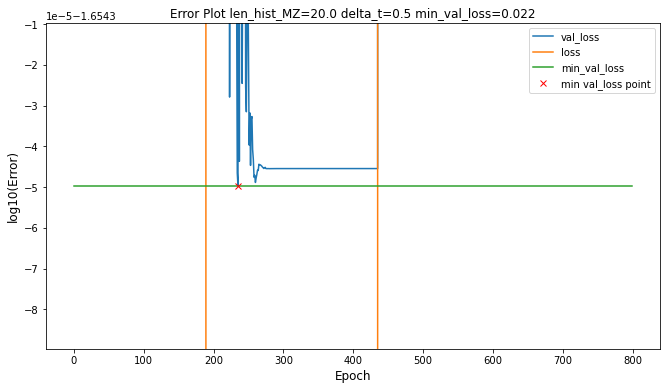

In [103]:
i_combo=0
i_hist_MZ=combinations[i_combo,0]
i_Delta=combinations[i_combo,1]
len_hist_MZ=int(i_hist_MZ)
a=.00004
for i_start in range(1):
    plt.figure(figsize=(11,6))
#     plt.title('Error Plot Activation='+ inits[i_start%(len(inits)-1)]+' len_hist_MZ=' + str(i_hist_MZ)
#               +' delta_t=' + str(i_Delta)+' min_val_loss=' + str(round(min_log[i_combo,i_start],3)))
    plt.title('Error Plot len_hist_MZ=' + str(i_hist_MZ)
          +' delta_t=' + str(i_Delta)+' min_val_loss=' + str(round(min_log[i_combo,i_start],3)))
#     x=range(len(val_loss_log[i_start,:]-1200))
    x=range(800)
    plt.plot(x,np.log10(val_loss_log[i_combo,i_start,0:800]), label='val_loss')
    plt.plot(x,np.log10(loss_log[i_combo,i_start,0:800]), label='loss')
    plt.plot(x,np.min(np.log10(val_loss_log[i_combo,i_start,0:800]))*np.ones(len(x)), label='min_val_loss')
    plt.plot(np.argmin(val_loss_log[i_combo,i_start,:]),np.min(np.log10(val_loss_log[i_combo,i_start,:])),'rx', label='min val_loss point')
    plt.ylim(np.nanmin(np.log10(val_loss_log[i_combo,i_start,:]))-a,np.nanmin(np.log10(val_loss_log[i_combo,i_start,:]))+a)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('log10(Error)', fontsize=12)
    plt.legend()
    plt.show()

In [80]:

# best_start=np.loadtxt(data_dir+'/best_start'+ str(len(combinations)) +'.txt')
best_start[i_combo]=1
np.savetxt(data_dir+'/best_start'+ str(len(combinations)) +'.txt', best_start)

NameError: name 'best_start' is not defined

## Test

Generate the reference solution with $x_1(0)=0$ and $x_2(0)=1$.

In [781]:
best_start

array([0., 1., 1., 1., 1., 1., 2., 3., 1., 1., 1., 0., 1., 1., 0., 2., 2.,
       2., 1., 0., 1., 2., 2., 1., 1., 1., 2., 0., 1., 0., 0., 2., 0., 1.,
       2., 1.])

In [784]:
def Best_Model_MSE(i_combo,y_shift,Delta,x_init,t_shift,t):
    delta_gen=.02
    i_start=int(best_start[i_combo])
    model_path=checkpoint_dir+"/opt_model_big_NN" +str(i_start)+'_' +str(i_combo) +".h5"
    model=tf.keras.models.load_model(model_path)
    len_hist_MZ=model.get_weights()[0].shape[0]
    delta_int=int(Delta/delta_gen)
    y_ref=np.load(data_dir+'/y_ref_c='+str(x_init)+'.npy') 
    start_iter=int(t_shift/Delta)+len_hist_MZ
    end_iter=int((t_shift+t)/Delta)+len_hist_MZ
    y_predict=np.zeros(end_iter)
    y_predict[0:start_iter]=y_ref[0:start_iter*delta_int:delta_int,2]
    for i in range(start_iter,end_iter):
        y_predict[i]=y_predict[i-1]+y_shift.inverse(model.predict(np.array([y_predict[i-len_hist_MZ:i]])))
    MSE=bursting_util.mean_squared_error(y_ref[start_iter*delta_int:end_iter*delta_int:delta_int,2],
                                         y_predict[start_iter:end_iter])
    return MSE

In [422]:
def Average_Model_MSE(i_combo,y_shift,Delta,x_init,t_shift,t):
    n_starts=3
    delta_gen=.02
    for i_start in range(n_starts):
        model_path=checkpoint_dir+"/opt_model_big_NN" +str(i_start)+'_' +str(i_combo) +".h5"
        exec('model'+str(i_start)+'=tf.keras.models.load_model(model_path)')
    len_hist_MZ=model0.get_weights()[0].shape[0]
    delta_int=int(Delta/delta_gen)
    y_ref=np.load(data_dir+'/y_ref_c='+str(x_init)+'.npy') 
    start_iter=int(t_shift/Delta)+len_hist_MZ
    end_iter=int((t_shift+t)/Delta)+len_hist_MZ
    y_predict=np.zeros(end_iter)
    y_predict[0:start_iter]=y_ref[0:start_iter*delta_int:delta_int,2]
    for i in range(start_iter,end_iter):
        y_predict[i]=y_predict[i-1]+sum([y_shift.inverse(model0.predict(np.array([y_predict[i-len_hist_MZ:i]]))),
                                        y_shift.inverse(model1.predict(np.array([y_predict[i-len_hist_MZ:i]]))),
                                        y_shift.inverse(model2.predict(np.array([y_predict[i-len_hist_MZ:i]])))])/n_starts
    MSE=bursting_util.mean_squared_error(y_ref[start_iter*delta_int:end_iter*delta_int:delta_int,2],
                                         y_predict[start_iter:end_iter])
    return MSE

NameError: name 'n_starts' is not defined

In [423]:
def Avg_MSE(i_combo,y_shift,Delta,x_init,t_shift,t,Average_or_Best):
    MSE_mat=np.zeros(x_init.shape[0])
    for i_init in range(x_init.shape[0]):
        exec('MSE_mat[i_init]='+Average_or_Best+'_Model_MSE(i_combo,y_shift,Delta,x_init[i_init],t_shift,t)')
    return np.mean(MSE_mat)

In [792]:
t_shift=0
max_time=40
time_of_measure=50
Avg_MSE_Mat=np.zeros(len(combinations))
best_start=np.loadtxt(data_dir+'/best_start'+ str(len(combinations)) +'.txt')
for i_combo in range(len(combinations)):
    i_hist_MZ=combinations[i_combo,0]
    i_Delta=combinations[i_combo,1]
    t_shift=int(max_time-i_hist_MZ*i_Delta)
    len_hist_MZ=int(i_hist_MZ)
    x=np.load(data_dir+'/x_delta_t='+str(i_Delta)+ 'MZ_hist='+str(i_hist_MZ) +'.npy')
    y_temp=np.load(data_dir+'/y_delta_t='+str(i_Delta)+ 'MZ_hist='+str(i_hist_MZ) +'.npy')
    exec('y_shift'+str(i_combo)+'=bursting_util.min_max_scale()')
    exec('y=y_shift'+str(i_combo)+'.fit_transform((y_temp-x[:,len_hist_MZ-1]).reshape(-1,1))')
    exec('y_shift=y_shift'+str(i_combo))
    Delta=combinations[i_combo,1]
    x_init=np.array([[-30.,1,0.],[-30.,.6,0.],[-30.,.45,0.],[-10.,.8,0.],[-30.,1.4,0.],[-20.,1.2,0.]])
    Average_or_Best='Best'
    Avg_MSE_Mat[i_combo]=Avg_MSE(i_combo,y_shift,Delta,x_init,t_shift, time_of_measure,Average_or_Best)
    print(i_combo)
np.save(checkpoint_dir+"/Avg_MSE_Mat_Big_NN_"+ Average_or_Best +'n_combo=' +str(len(combinations)) +"time=" +str(time_of_measure) +".npy", Avg_MSE_Mat)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [130]:
y_predict[i+shift:i+len_hist_MZ+shift].reshape([-1]).shape

(200,)

In [135]:
x.reshape([n_data,-1])[0].shape

(200,)

In [119]:
shift=0

ticksize=12
labelsize=14
i_combo=0
i_start=0
delta_gen=.05
n_bins=10
bin_size=13
model=tf.keras.models.load_model(checkpoint_dir+"/opt_model_first_try" +str(i_start)+ '_' +str(i_combo) +".h5")

In [136]:
shift=0
i_hist_MZ=combinations[i_combo,0]
Delta=combinations[i_combo,1]
n_steps= 100
len_hist_MZ=int(i_hist_MZ)
delta_int=int(Delta_t/delta_gen)
ref_traj=np.load(data_dir+'/ref_delta_t='+str(delta_gen)+'bin_n,l=' + str(n_bins)+'_'+str(bin_size) + '.npy')
y_predict=np.zeros([n_steps,n_bins])
y_predict[0:len_hist_MZ+shift]=ref_traj[0,0:len_hist_MZ*delta_int+shift:delta_int]
exec('y_shift=y_shift'+str(i_combo))
for i in range(n_steps-len_hist_MZ-shift):
    y_temp=y_predict[i+shift:i+len_hist_MZ+shift].reshape([-1])
    y_predict[i+len_hist_MZ+shift]=y_predict[i+len_hist_MZ+shift-1]+y_shift.inverse(model.predict(np.array([y_temp])))


In [153]:
y_predict[0]-ref_traj[0,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<function matplotlib.pyplot.show(*args, **kw)>

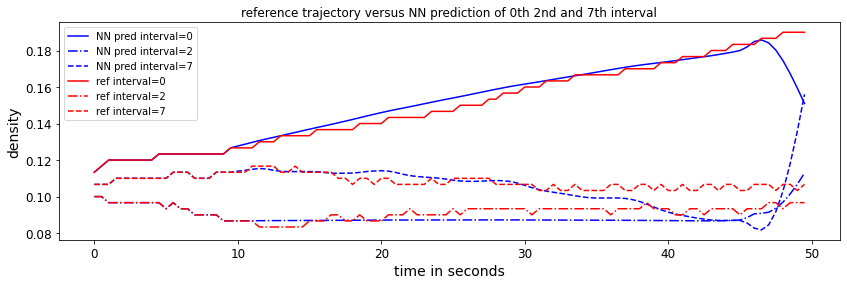

In [156]:
plt.figure(figsize=(14,4))
num_period_from_end=2
plt.plot(np.arange(n_steps)*Delta_t, y_predict[:,0], 'b-', label='NN pred interval=0')
plt.plot(np.arange(n_steps)*Delta_t, y_predict[:,2], 'b-.', label='NN pred interval=2')
plt.plot(np.arange(n_steps)*Delta_t, y_predict[:,7], 'b--', label='NN pred interval=7')
plt.plot(np.arange(n_steps)*Delta_t, ref_traj[0,:n_steps*delta_int:delta_int,0], 'r-', label='ref interval=0')
plt.plot(np.arange(n_steps)*Delta_t, ref_traj[0,:n_steps*delta_int:delta_int,2], 'r-.', label='ref interval=2')
plt.plot(np.arange(n_steps)*Delta_t, ref_traj[0,:n_steps*delta_int:delta_int,7], 'r--', label='ref interval=7')


plt.title('reference trajectory versus NN prediction of 0th 2nd and 7th interval')
# plt.ylim(-2,5)
plt.xlabel('time in seconds', fontsize=labelsize)
plt.ylabel('density', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.legend()
plt.show

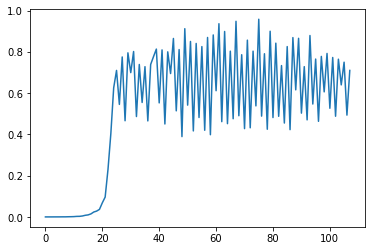

In [691]:
Combo_18_Period_MSE=Period_MSE(y_ref,y_predict,47,combinations[i_combo,0],combinations[i_combo,1])
plt.plot(Combo_18_Period_MSE)

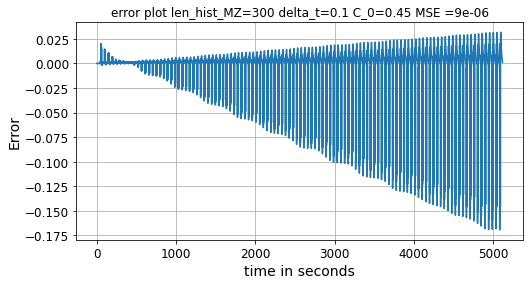

In [170]:
plt.figure(figsize=(8,4))
delta_int=int(Delta/.02)
MeanSE=bursting_util.mean_squared_error(y_ref[len_hist_MZ*delta_int:len_hist_MZ*delta_int+6500:delta_int,2],y_predict[len_hist_MZ:len_hist_MZ+int(130/Delta)])
plt.title('error plot'+' len_hist_MZ=' + str(len_hist_MZ)+' delta_t=' + str(Delta)+ ' C_0='+ str(y_ref[0,2]) +' MSE ='+ str(round(MeanSE,6)))
residual=y_ref[::delta_int,2]-y_predict
plt.plot(y_ref[:256000:delta_int,0],residual[:51200])
plt.xlabel('time in seconds', fontsize=labelsize)
plt.ylabel('Error', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid(b=None, which='major', axis='both')
plt.show()

In [10]:
def Bursting_RK4 (x_init,delta_t,t_start,t_end):
    if (.00001+t_end-t_start)%delta_t-.00001>10**-11:
        print((.00001+t_end-t_start)%delta_t-.00001)
        print('time interval must be divisible by delta_t')
        return
    n_iter=int(round((t_end-t_start)/delta_t))
    x=np.zeros([x_init.shape[0],n_iter])
    x[:,0]=x_init

    for i_iter in range ( 0, n_iter-1 ):

        f1 = bursting_data_generator.rhs_f_linear(x[:,i_iter] ,0)
        f2 = bursting_data_generator.rhs_f_linear(x[:,i_iter] + delta_t * f1 / 2.0 ,0)
        f3 = bursting_data_generator.rhs_f_linear(x[:,i_iter] + delta_t * f2 / 2.0 ,0)
        f4 = bursting_data_generator.rhs_f_linear(x[:,i_iter] + delta_t * f3,0 )

        x[:,i_iter+1] = x[:,i_iter] + delta_t * ( f1 + 2.0 * f2 + 2.0 * f3 + f4 ) / 6.0

    return x

In [701]:

# y_RK4_02=Bursting_RK4(x_init[2],.02,0,4000)
RK4_1_Period_MSE=Period_MSE(y_ref,y_RK4_1[1],47,0,.1)

In [672]:
y_Huen_0005=Bursting_Huen (x_init[2],.0005,0,4000)
Huen_0005_Period_MSE=Period_MSE(y_ref,y_Huen_0005[1],47,0,.0005)

In [ ]:
y_Huen_001=Bursting_Huen (x_init[2],.001,0,4000)
Huen_001_Period_MSE=Period_MSE(y_ref,y_Huen_001[1],47,0,.001)


Text(0, 0.5, 'Mean Error=||y*-y||_2/sqrt(length of period)')

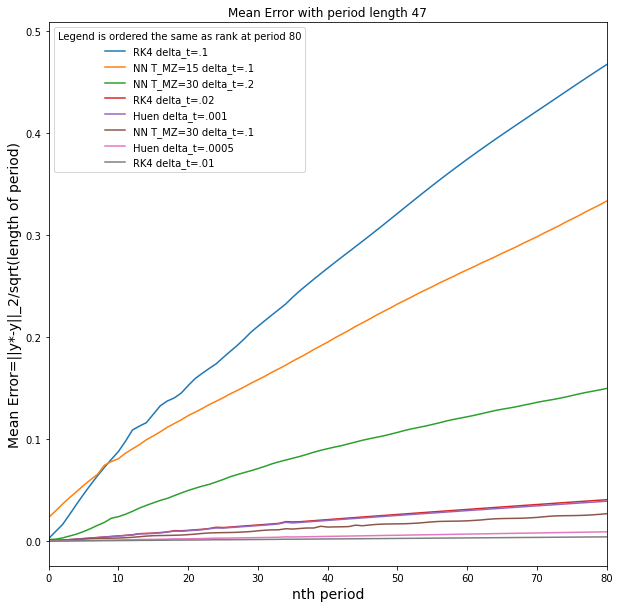

In [710]:
plt.figure(figsize=(10,10))
# plt.plot(np.sqrt(Combo_18_Period_MSE),label='NN T_MZ=39 delta_t=1.')
plt.plot(np.sqrt(RK4_1_Period_MSE),label='RK4 delta_t=.1')
plt.plot(np.sqrt(Combo_27_Period_MSE),label='NN T_MZ=15 delta_t=.1')
plt.plot(np.sqrt(Combo_26_Period_MSE),label='NN T_MZ=30 delta_t=.2')
plt.plot(np.sqrt(RK4_02_Period_MSE),label='RK4 delta_t=.02')
plt.plot(np.sqrt(Huen_001_Period_MSE),label='Huen delta_t=.001')
plt.plot(np.sqrt(Combo_25_Period_MSE),label='NN T_MZ=30 delta_t=.1')
plt.plot(np.sqrt(Huen_0005_Period_MSE),label='Huen delta_t=.0005')
plt.plot(np.sqrt(RK4_01_Period_MSE),label='RK4 delta_t=.01')
plt.legend(title='Legend is ordered the same as rank at period 80')
plt.title('Mean Error with period length 47')
plt.xlim([0,80])
plt.xlabel('nth period', fontsize=labelsize)
plt.ylabel('Mean Error=||y*-y||_2/sqrt(length of period)', fontsize=labelsize)

0
1
2


In [11]:
def Bursting_Huen (x_init,delta_t,t_start,t_end):
    if (.00001+t_end-t_start)%delta_t-.00001>10**-11:
        print((.00001+t_end-t_start)%delta_t-.00001)
        print('time interval must be divisible by delta_t')
        return
    n_iter=int(round((t_end-t_start)/delta_t))
    x=np.zeros([x_init.shape[0],n_iter])
    x[:,0]=x_init
    y=np.zeros([x_init.shape[0],2])
    t=0
    for i_iter in range(n_iter-1):
        y[:,0]=bursting_data_generator.rhs_f_linear(x[:,i_iter], t)
        y[:,1]=bursting_data_generator.rhs_f_linear(x[:,i_iter]+delta_t*y[:,0], t)
        x[:,i_iter+1]=x[:,i_iter]+delta_t*np.mean(y,axis=1)
    return x

In [12]:
def Numerical_MSE(x_init,delta_t,t,Numerical_Method):
    max_time=40
    y_ref=np.load(data_dir+'/y_ref_c='+str(x_init)+'.npy')
    delta_gen=.02
    if delta_gen>delta_t:
        ratio=int(round(delta_gen/delta_t))
        start_iter=int(round(max_time/delta_gen))
        end_iter=int(round((max_time+t)/delta_gen))
        y_predict=np.zeros(end_iter*ratio)
        y_predict[0:start_iter*ratio:ratio]=y_ref[0:start_iter,2]
        y_predict[start_iter*ratio-ratio:end_iter*ratio]=Numerical_Method(y_ref[start_iter-1,1:4],delta_t,0,t+ratio*delta_t)[1]
        MSE=bursting_util.mean_squared_error(y_ref[start_iter:end_iter,2],
                                y_predict[start_iter*ratio:end_iter*ratio:ratio])

    else:
        ratio=int(round(delta_t/delta_gen))
        start_iter=int(round(max_time/delta_t))
        end_iter=int(round((max_time+t)/delta_t))
        y_predict=np.zeros(end_iter)
        y_predict[0:start_iter]=y_ref[0:start_iter*ratio:ratio,2]
        y_predict[start_iter-1:end_iter]=Numerical_Method(y_ref[start_iter*ratio-ratio,1:4],delta_t,0,t+delta_t)[1]
        MSE=bursting_util.mean_squared_error(y_ref[start_iter*ratio:end_iter*ratio:ratio,2],
                                         y_predict[start_iter:end_iter])
    return MSE

In [13]:
def Numerical_Avg_MSE(x_init,delta_t,t,Numerical_Method):
    MSE_mat=np.zeros(x_init.shape[0])
    for i_init in range(x_init.shape[0]):
        MSE_mat[i_init]=Numerical_MSE(x_init[i_init],delta_t,t,Numerical_Method)
    return np.mean(MSE_mat)

ValueError: x and y must have same first dimension, but have shapes (80000,) and (0,)

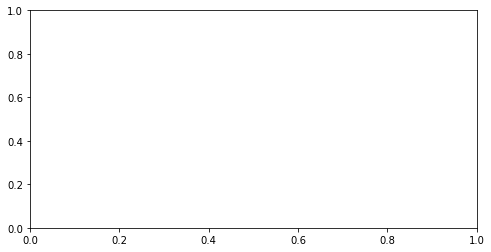

In [452]:
plt.figure(figsize=(8,4))
plt.plot(np.linspace(39920,40000,round(80/.001)),y[1,round(39920/.001):round(40000/.001)],label='Huen approximation')
y_ref=np.load(data_dir+'/y_ref_c='+str(x_init[2])+'.npy')
plt.plot(y_ref[round(39920/.02):round(40000/.02),0],y_ref[round(39920/.02):round(40000/.02),2],label='reference')
plt.xlabel("time in seconds", fontsize=14)
plt.ylabel('C', fontsize=14)
plt.title('Huen Approximation of System')
plt.legend()
plt.grid(True)
plt.show
# plt.figure(figsize=(14,4))
# plt.plot(y_ref[0:round(40000/.02),0],y_ref[0:round(40000/.02),2]-y[1,0:round(40000/.001):20])
# plt.grid(True)
# plt.xlabel("time in seconds", fontsize=14)
# plt.ylabel('residual', fontsize=14)
# plt.title('Residual with Respect to Time for Huen Approximation of System')
# plt.show

In [14]:
def Period_MSE(y_ref,y_predict,length_period,t_start,delta_t):
#     put in a start_t
    delta_gen=.02
    error_list=np.zeros(int((np.min([(len(y_predict)*delta_t),(len(y_ref)*delta_gen)])-t_start)/length_period))
    
    for i_period in range(len(error_list)):

        if delta_gen>delta_t:
            start_iter=int(round((i_period*length_period+t_start)/delta_gen))
            end_iter=int(round(((i_period+1)*length_period+t_start)/delta_gen))
            ratio=int(round(delta_gen/delta_t))
            error_list[i_period]=bursting_util.mean_squared_error(y_ref[start_iter:end_iter,2],
                                         y_predict[start_iter*ratio:end_iter*ratio:ratio])

        else:
            start_iter=int(round((i_period*length_period+t_start)/delta_t))
            end_iter=int(round(((i_period+1)*length_period+t_start)/delta_t))
            delta_int=int(round(delta_t/delta_gen))
            error_list[i_period]=bursting_util.mean_squared_error(y_ref[start_iter*delta_int:end_iter*delta_int:delta_int,2],
                                         y_predict[start_iter:end_iter])
    return error_list


In [58]:
time_of_measure=3
t_shift=0
max_time=40
RK4_time_values=np.array([.04,.02,.01,.005])
RK4_Avg_MSE_Mat=np.zeros(len(RK4_time_values))
Numerical_Method=Bursting_RK4
for i_value in range(len(RK4_time_values)):
    delta_t=RK4_time_values[i_value]
    x_init=np.array([[-30.,1,0.],[-30.,.6,0.],[-30.,.45,0.],[-10.,.8,0.],[-30.,1.4,0.],[-20.,1.2,0.]])
    RK4_Avg_MSE_Mat[i_value]=Numerical_Avg_MSE(x_init,RK4_time_values[i_value],time_of_measure,Numerical_Method)
Huen_time_values=np.array([.02,.01,.005])
Huen_Avg_MSE_Mat=np.zeros(len(Huen_time_values))
Numerical_Method=Bursting_Huen
for i_value in range(len(Huen_time_values)):
    delta_t=Huen_time_values[i_value]
    x_init=np.array([[-30.,1,0.],[-30.,.6,0.],[-30.,.45,0.],[-10.,.8,0.],[-30.,1.4,0.],[-20.,1.2,0.]])
    Huen_Avg_MSE_Mat[i_value]=Numerical_Avg_MSE(x_init,Huen_time_values[i_value],time_of_measure,Numerical_Method)

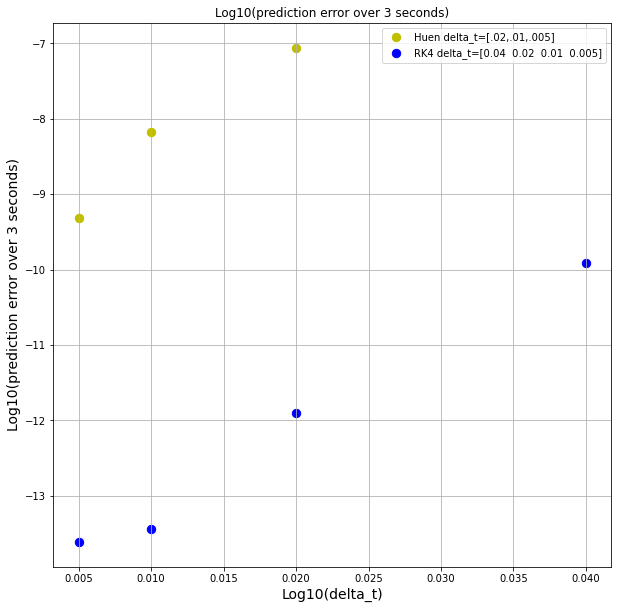

In [59]:
import matplotlib.cbook as cbook
def f(x):
    return np.log10(x)
#     return (x)
def f_time(x):
#     return np.log10(x)
    return (x)

plt.figure(figsize=(10,10))

plt.scatter(f_time(Huen_time_values), f(Huen_Avg_MSE_Mat), c='y',s=70,label='Huen delta_t=[.02,.01,.005]')
plt.scatter(f_time(RK4_time_values), f(RK4_Avg_MSE_Mat), c='b',s=70,label='RK4 delta_t='+str(RK4_time_values))
plt.title('Log10(prediction error over ' +str(time_of_measure)+ ' seconds)')
plt.xlabel("Log10(delta_t)", fontsize=14)
plt.ylabel("Log10(prediction error over " +str(time_of_measure)+ " seconds)", fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

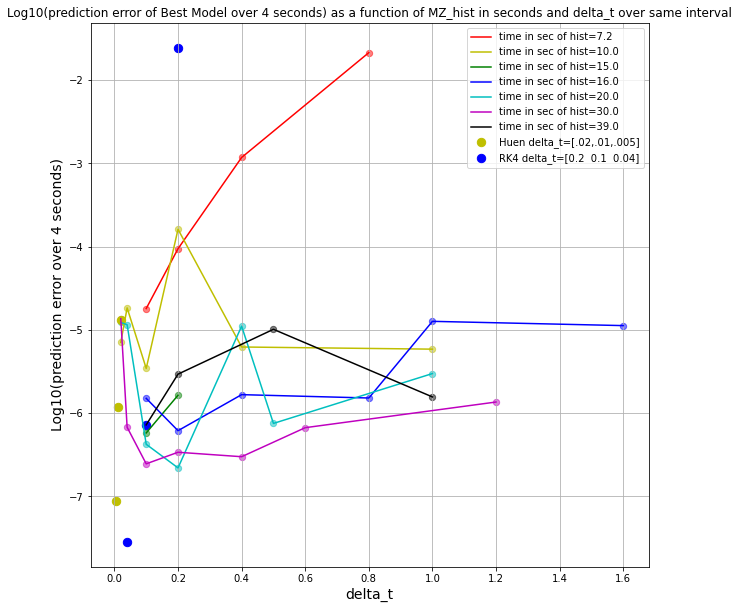

In [802]:
import matplotlib.cbook as cbook
def f(x):
#     return np.log10(x)
    return (x)

time_of_measure=4
Average_or_Best='Best'
# Avg_MSE_Mat=np.load(checkpoint_dir+"/Avg_MSE_Mat_Big_NN_"+ Average_or_Best +'n_combo=' +str(29) +"time=" +str(time_of_measure) +".npy")
Avg_MSE_Mat=np.load(checkpoint_dir+"/Avg_MSE_Mat_Big_NN_"+ Average_or_Best +'n_combo=' +str(len(combinations)) +"time=" +str(time_of_measure) +".npy")
plt.figure(figsize=(10,10))
times=combinations[:,0]*combinations[:,1]

uniq_times=np.unique(times)
sorted_order=np.argsort(combinations[:,1])
sorted_combinations=combinations[sorted_order]
sorted_Avg_MSE_Mat=Avg_MSE_Mat[sorted_order]
sorted_times=times[sorted_order]

colors=['r','y','g','b','c','m','k']

for i in range(len(uniq_times)):
    i_uniq=uniq_times[i]
    plt.scatter(f(sorted_combinations[sorted_times==i_uniq,1]), np.log10(sorted_Avg_MSE_Mat[sorted_times==i_uniq]), 
                c=colors[int(np.mod(i,len(colors)))], s=40, alpha=0.5)
    plt.plot(f(sorted_combinations[sorted_times==i_uniq,1]), np.log10(sorted_Avg_MSE_Mat[sorted_times==i_uniq]),
             c=colors[int(np.mod(i,len(colors)))],label='time in sec of hist=' +str(i_uniq))

plt.scatter(f(Huen_time_values), np.log10(Huen_Avg_MSE_Mat), c='y',s=70,label='Huen delta_t=[.02,.01,.005]')
plt.scatter(f(RK4_time_values), np.log10(RK4_Avg_MSE_Mat), c='b',s=70,label='RK4 delta_t='+str(RK4_time_values))
plt.title('Log10(prediction error of ' +Average_or_Best +' Model over ' +str(time_of_measure)+ 
          ' seconds) as a function of MZ_hist in seconds and delta_t over same interval')
plt.xlabel("delta_t", fontsize=14)
plt.ylabel("Log10(prediction error over " +str(time_of_measure)+ " seconds)", fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

(array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Text major ticklabel objects>)

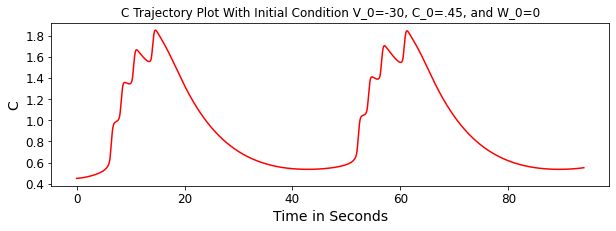

In [644]:
shift=0
i_hist_MZ=combinations[i_combo,0]
Delta=combinations[i_combo,1]
n_steps= int(5120/Delta)
len_hist_MZ=int(i_hist_MZ)
# for i_init in range(x_init.shape[0]):
i_init=2
delta_int=int(Delta/.02)
y_ref=np.load(data_dir+'/y_ref_c='+str(x_init[i_init])+'.npy')

plt.figure(figsize=(10,3))
plt.plot(y_ref[:4700,0], y_ref[:4700,2], 'r-', label='reference')
# plt.plot(y_ref[:18800,0], y_ref[:18800,2], 'r-', label='reference')
plt.title('C Trajectory Plot With Initial Condition V_0=-30, C_0=.45, and W_0=0')
plt.xlabel('Time in Seconds', fontsize=labelsize)
plt.ylabel('C', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
# plt.legend()

4
9
12
13
14
20
21
22


No handles with labels found to put in legend.


23


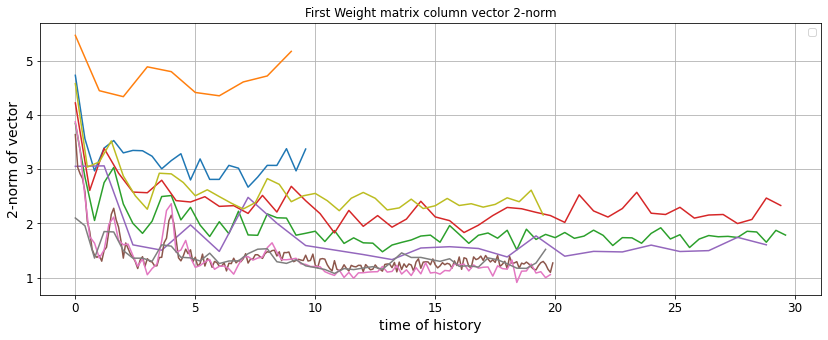

In [762]:
plt.figure(figsize=(14,5))
for i_combo in [4,9,12,13,14,20,21,22,23]:
    i_start=best_start[int(i_combo)]
    i_hist_MZ=combinations[i_combo,0]
    len_hist_MZ=int(i_hist_MZ)
    Delta=combinations[i_combo,1]
    opt_model_path=checkpoint_dir+"/opt_model_big_NN" +str(int(i_start))+ '_' +str(i_combo) +".h5"
    model=tf.keras.models.load_model(opt_model_path)
    length=model.get_weights()[0].shape[0]
    height=model.get_weights()[0].shape[1]
    column_vector_2norm=np.zeros(length)
    for i_length in range(length):
        column_vector_2norm[i_length]=np.linalg.norm(model.get_weights()[0][i_length])
    plt.plot(np.linspace(0,Delta*len_hist_MZ,len_hist_MZ+1)[0:len_hist_MZ],column_vector_2norm[::-1])
    print(i_combo)



plt.title('First Weight matrix column vector 2-norm')
plt.xlabel('time of history', fontsize=labelsize)
plt.ylabel('2-norm of vector', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid(b=None, which='major', axis='both')
plt.legend()
plt.show()